# Exercise 01 - Multi-armed Bandits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

Create classes for bandit and Q-learning with epsilon-greedy strategy

In [17]:
class GaussianBandit:

    var_reward = .5

    def __init__(self, k=10):
        self._arm_means = np.random.uniform(0., 1., k)  # Sample some means
        self.n_arms = len(self._arm_means)
        self.rewards = []
        self.total_played = 0

    def reset(self):
        self.rewards = []
        self.total_played = 0

    def play_arm(self, a):
        reward = np.random.normal(self._arm_means[a], self.var_reward)  # Use sampled mean and covariance of 1.
        self.total_played += 1
        self.rewards.append(reward)
        return reward

def trans_fun(x,f0=0.9,fe=0.05, xtrans=0.15, k=40): 
    frange = fe-f0
    return f0+frange*1/(np.exp(-k*(x-xtrans))+1)

def greedy(bandit:GaussianBandit, timesteps=1000):
    return epsilon_greedy(bandit, timesteps, epsilon=0, adaptepsilon=False)

def epsilon_greedy(bandit:GaussianBandit, timesteps=1000, epsilon=0.1, lr=0.8, adaptepsilon=True):
    rewards = np.zeros(bandit.n_arms)
    n_plays = np.zeros(bandit.n_arms)
    Q = np.zeros(bandit.n_arms)
    possible_arms = range(bandit.n_arms)

    for tperc in np.linspace(0,1,timesteps): # while bandit.total_played < timesteps:

        epsilon_t = trans_fun(tperc,fe=epsilon) if adaptepsilon else epsilon

        # with probability 1-epsilon take the greedy action
        takegreedyaction = np.random.default_rng().binomial(1, 1-epsilon_t)
        a = np.argmax(Q) if takegreedyaction else random.choice(possible_arms)
        
        # update Q-value function for the selected arm
        rewards[a] += bandit.play_arm(a)
        n_plays[a] += 1
        Qnewa = rewards[a]/n_plays[a]
        Q[a] = Q[a] + lr*(Qnewa - Q[a])
    
    return bandit.rewards

This is how one can adapt the parameter $\epsilon$, such that in the beginning we explore and in the end we exploit more the state-action space

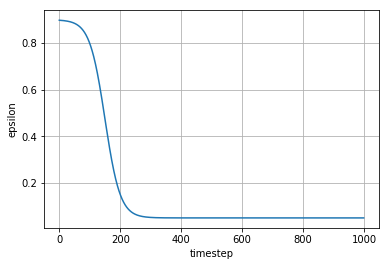

In [18]:
n_timesteps = 1000
plt.plot(range(n_timesteps), trans_fun(np.linspace(0,1,n_timesteps)))
plt.grid(True)
plt.xlabel('timestep')
plt.ylabel('epsilon');

Simulate

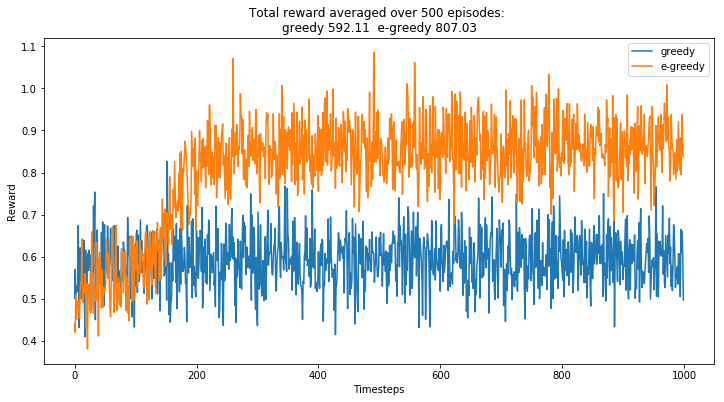

In [19]:

def main():
    n_episodes = 500  # set to 10000 to decrease noise in plot
    n_timesteps = 1000
    rewards_greedy = np.zeros(n_timesteps)
    rewards_egreedy = np.zeros(n_timesteps)

    params = [ (GaussianBandit(), n_timesteps) for _ in range(n_episodes) ]

    with mp.Pool(processes=mp.cpu_count()) as pool:
        rewards_egreedy = pool.starmap_async(epsilon_greedy, params).get()
        rewards_egreedy = np.average( rewards_egreedy, axis=0)

        rewards_greedy = pool.starmap_async(greedy, params).get()
        rewards_greedy = np.average( rewards_greedy, axis=0)

    fig = plt.figure(figsize=(12, 6))
    plt.plot(rewards_greedy, label="greedy")
    plt.plot(rewards_egreedy, label="e-greedy")
    plt.title(f"Total reward averaged over {n_episodes} episodes: \ngreedy {np.sum(rewards_greedy):.2f}  e-greedy {np.sum(rewards_egreedy):.2f}")
    plt.legend()
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.savefig('bandit_strategies.eps')
    plt.show()


if __name__ == "__main__":
    main()
